In [112]:
import matplotlib.pyplot as plt
import scienceplots


import numpy as np
import scipy.stats
import pandas as pd

import datetime

import sqlalchemy as sqla

In [2]:
plt.style.use(['science','no-latex'])

In [7]:
from scipy.stats import norm

In [116]:
rv = norm(loc=43200, scale=7200)

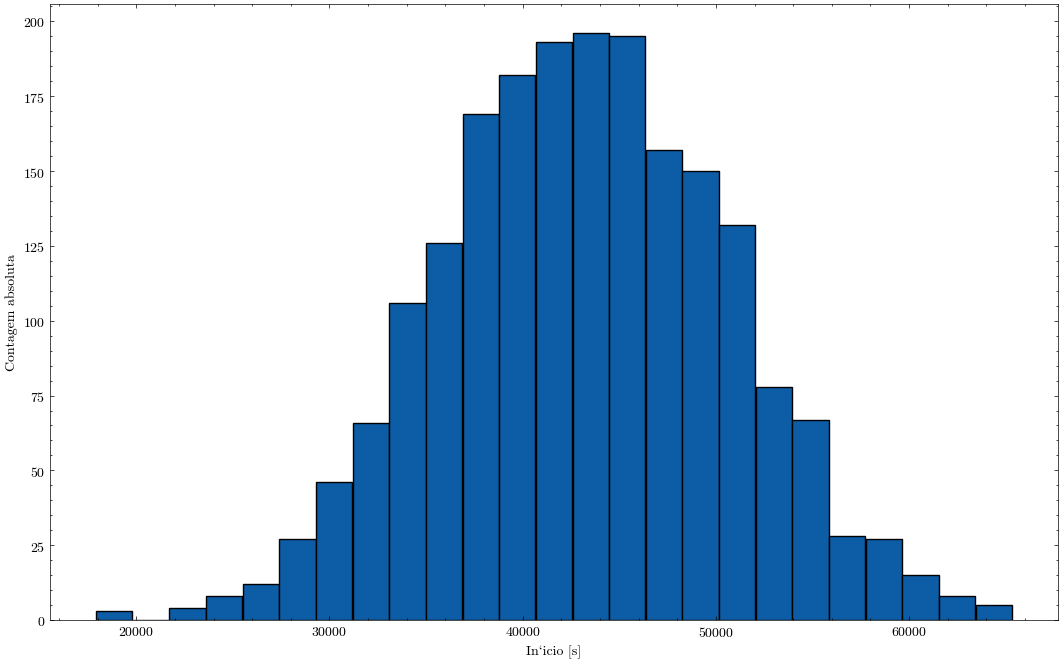

In [86]:
fig, ax = plt.subplots(figsize=(13,8))

ax.hist(rv.rvs(2000), bins=25, rwidth=0.99, edgecolor='black')
ax.set(xlabel='In`icio [s]', ylabel='Contagem absoluta')
plt.show()

# fig.savefig(bbox_inches='tight', fname='temp.pdf')

In [89]:
ids_jogadores = np.arange(1, 40000+1, dtype=int)

In [106]:
np.int32(np.floor(1e6))

1000000

In [123]:
data = datetime.datetime(datetime.date.today().year, datetime.date.today().month, datetime.date.today().day) 

In [124]:
data

datetime.datetime(2025, 3, 3, 0, 0)

In [121]:
rv.rvs(1)[0]

42882.29313519225

In [146]:
(data + datetime.timedelta(seconds=rv.rvs(1)[0])).isoformat()

'2025-03-03T15:09:05.015171'

In [113]:
ids_jogadores_sessoes = np.random.choice(ids_jogadores, np.int32(np.floor(5000)))

